# Uplift modeling

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -U lightautoml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 319 kB 4.2 MB/s 
     |████████████████████████████████| 546 kB 40.1 MB/s 
     |████████████████████████████████| 215 kB 47.4 MB/s 
     |████████████████████████████████| 76.6 MB 83.1 MB/s 
     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 2.0 MB 46.9 MB/s 
     |████████████████████████████████| 348 kB 45.1 MB/s 
     |████████████████████████████████| 2.8 MB 52.3 MB/s 
     |████████████████████████████████| 81 kB 9.9 MB/s 
     |████████████████████████████████| 209 kB 56.9 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 147 kB 71.5 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 112 kB 67.2 MB/s 
     |████████████████████████████████| 24.3 MB 1.3 MB/s 
     |██████████████████████████████

## Import necessary libraries

In [ ]:
# Standard python libraries
from copy import deepcopy
import os
import requests

# Installed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

from lightautoml.addons.uplift.base import AutoUplift, BaseLearnerWrapper, MetaLearnerWrapper
from lightautoml.addons.uplift import metalearners
from lightautoml.addons.uplift.metrics import (_available_uplift_modes,
                                               TUpliftMetric,
                                               calculate_graphic_uplift_curve,
                                               calculate_min_max_uplift_auc,
                                               calculate_uplift_at_top,
                                               calculate_uplift_auc,
                                               perfect_uplift_curve)
from lightautoml.addons.uplift.utils import create_linear_automl
from lightautoml.report.report_deco import ReportDecoUplift


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})
%matplotlib inline

## Parameters

### Setting

In [ ]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 300 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name
TREATMENT_NAME = 'CODE_GENDER'

### Fix torch number of threads and numpy seed

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

## Example data load

Load a dataset from the repository if doesn't clone repository by git.

In [ ]:
DATASET_DIR = 'data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

In [ ]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

CPU times: user 64.2 ms, sys: 20.8 ms, total: 85 ms
Wall time: 1.2 s


In [ ]:
data = pd.read_csv(DATASET_FULLNAME)
data.head()

CPU times: user 132 ms, sys: 35.2 ms, total: 168 ms
Wall time: 175 ms


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


## (Optional) Some user feature preparation

In [ ]:
data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)
data['report_dt'] = np.datetime64('2018-01-01')
data['constant'] = 1
data['allnan'] = np.nan
data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)
data['CODE_GENDER'] = (data['CODE_GENDER'] == 'M').astype(int)

CPU times: user 125 ms, sys: 5.72 ms, total: 130 ms
Wall time: 136 ms


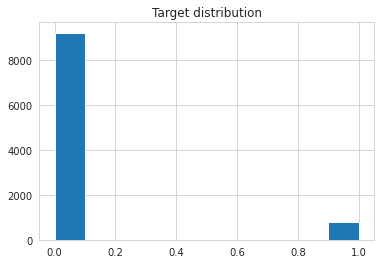

In [ ]:
plt.hist(data[TARGET_NAME])
plt.title('Target distribution')
plt.show()

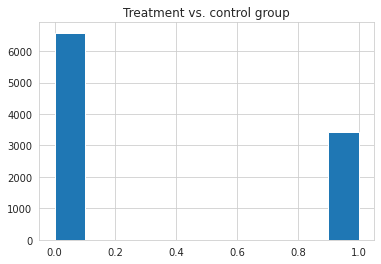

In [ ]:
plt.hist(data[TREATMENT_NAME])
plt.title('Treatment vs. control group')
plt.show()

In [ ]:
print(f'Control group mean conversion:, {data[data[TREATMENT_NAME] == 0][TARGET_NAME].mean():.4f}')
print(f'Target group mean conversion:, {data[data[TREATMENT_NAME] == 1][TARGET_NAME].mean():.4f}')

Control group mean conversion:, 0.0706
Target group mean conversion:, 0.0978


## Data splitting for train-test

In [ ]:
stratify_value = data[TARGET_NAME] + 10 * data[TREATMENT_NAME]
train, test = train_test_split(data, test_size=3000, stratify=stratify_value, random_state=42)
test_target, test_treatment = test[TARGET_NAME].values.ravel(), test[TREATMENT_NAME].values.ravel()

## Setup columns roles

In [ ]:
roles = {
    'target': TARGET_NAME,
    'treatment': TREATMENT_NAME,
    DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt'
}

## AutoUplift (use predefined uplift methods)

### Fit autouplift

In [ ]:
%%time

task = Task('binary')

autouplift = AutoUplift(task,
                        metric='adj_qini',
                        has_report=True,
                        test_size=0.2,
                        timeout=200,
)

autouplift.fit(train, roles, verbose=1)

[14:50:02] Train data shape: (1912, 124)



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:lightautoml.reader.base:Train data shape: (1912, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: ['REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_18']


[14:50:04] Layer 1 train process start. Time left 9999999998.51 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.51 secs


[14:50:04] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196], 'embed_sizes': array([12,  6,  3,  3, 35,  5,  4,  4, 12,  7,  3,  4, 47, 13,  8, 24, 13,
        8,  3], dtype=int32), 'data_size': 197}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7209763539282991
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7272311212814645
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7339435545385202
INFO3:lightautoml.ml_algo.tor

[14:50:07] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.71418739827947


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.71418739827947


[14:50:07] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:50:07] Time left 9999999994.65 secs



INFO:lightautoml.automl.base:Time left 9999999994.65 secs



[14:50:07] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:50:07] Train data shape: (3688, 124)



INFO:lightautoml.reader.base:Train data shape: (3688, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: ['WEEKDAY_APPR_PROCESS_START']


[14:50:09] Layer 1 train process start. Time left 9999999998.48 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.48 secs


[14:50:10] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211], 'embed_sizes': array([19, 15,  6,  5, 15,  5,  3,  5,  9, 16,  9,  4,  7,  3,  6, 49, 13,
        8, 36, 13,  8,  6,  6,  7,  9,  9,  8, 11, 11, 11, 11],
      dtype=int32), 'data_size': 212}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6398575913882036
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6604059206100023
INFO3:lightautoml.

[14:50:17] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7315916434790413


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7315916434790413


[14:50:17] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:50:17] Time left 9999999990.82 secs



INFO:lightautoml.automl.base:Time left 9999999990.82 secs



[14:50:17] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:50:17] Uplift candidate #0 [__TLearner__Default__] is fitted


INFO:lightautoml.addons.uplift.base:Uplift candidate #0 [__TLearner__Default__] is fitted


[14:50:17] Train data shape: (5600, 124)



INFO:lightautoml.reader.base:Train data shape: (5600, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: ['FLAG_CONT_MOBILE', 'REG_REGION_NOT_LIVE_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_19']


[14:50:19] Layer 1 train process start. Time left 9999999998.00 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.00 secs


[14:50:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], 'embed_sizes': array([ 8, 20,  6,  3,  3,  6,  9,  9,  7,  3,  5, 49, 13,  8, 37, 13,  8],
      dtype=int32), 'data_size': 184}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.761746690237396
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7713084234653931
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7765657825281379
INFO3:lightautoml.ml_algo.torch_based.linear_mode

[14:50:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8668794076003595


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8668794076003595


[14:50:40] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:50:40] Time left 9999999976.79 secs



INFO:lightautoml.automl.base:Time left 9999999976.79 secs



[14:50:40] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:50:40] Train data shape: (3688, 124)



INFO:lightautoml.reader.base:Train data shape: (3688, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: ['WEEKDAY_APPR_PROCESS_START']


[14:50:42] Layer 1 train process start. Time left 9999999998.05 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.05 secs


[14:50:43] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211], 'embed_sizes': array([19, 15,  6,  5, 15,  5,  3,  5,  9, 16,  9,  4,  7,  3,  6, 49, 13,
        8, 36, 13,  8,  6,  6,  7,  9,  9,  8, 11, 11, 11, 11],
      dtype=int32), 'data_size': 212}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6407546535097555
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6616954474097331
INFO3:lightautoml.

[14:50:50] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7320639978457948


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7320639978457948


[14:50:50] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:50:50] Time left 9999999990.33 secs



INFO:lightautoml.automl.base:Time left 9999999990.33 secs



[14:50:50] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:50:50] Train data shape: (1912, 124)



INFO:lightautoml.reader.base:Train data shape: (1912, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: ['REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_18']


[14:50:51] Layer 1 train process start. Time left 9999999998.75 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.75 secs


[14:50:52] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196], 'embed_sizes': array([12,  6,  3,  3, 35,  5,  4,  4, 12,  7,  3,  4, 47, 13,  8, 24, 13,
        8,  3], dtype=int32), 'data_size': 197}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7209763539282991
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7272311212814645
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7339435545385202
INFO3:lightautoml.ml_algo.tor

[14:50:55] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.71418739827947


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.71418739827947


[14:50:55] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:50:55] Time left 9999999994.80 secs



INFO:lightautoml.automl.base:Time left 9999999994.80 secs



[14:50:55] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:50:56] Train data shape: (3688, 124)



INFO:lightautoml.reader.base:Train data shape: (3688, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:50:57] Layer 1 train process start. Time left 9999999998.47 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.47 secs


[14:50:58] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191], 'embed_sizes': array([ 6,  3,  3,  9,  3,  5, 49, 13,  8, 36, 13,  8], dtype=int32), 'data_size': 192}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.07081095750818306
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.07039760722921498
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.07033066405882725
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.070545

[14:51:00] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.06252225227320929


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.06252225227320929


[14:51:00] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:51:00] Time left 9999999996.02 secs



INFO:lightautoml.automl.base:Time left 9999999996.02 secs



[14:51:00] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:51:00] Train data shape: (1912, 124)



INFO:lightautoml.reader.base:Train data shape: (1912, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: ['SK_ID_CURR', 'FLAG_CONT_MOBILE', 'REGION_RATING_CLIENT', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_21']


[14:51:01] Layer 1 train process start. Time left 9999999998.61 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.61 secs


[14:51:02] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207], 'embed_sizes': array([16,  6, 10,  3,  3, 11,  4, 13, 11, 35,  3,  5, 47, 13,  8, 24, 13,
        8, 11, 11], dtype=int32), 'data_size': 208}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.07485135897496556
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.07499940506023503
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.07516316685265033
INFO2:lightaut

[14:51:03] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.08283121063342454


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.08283121063342454


[14:51:03] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:51:03] Time left 9999999996.81 secs



INFO:lightautoml.automl.base:Time left 9999999996.81 secs



[14:51:03] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:51:03] Uplift candidate #1 [__XLearner__Default__] is fitted


INFO:lightautoml.addons.uplift.base:Uplift candidate #1 [__XLearner__Default__] is fitted


[14:51:04] Stdout logging level is INFO.


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:51:04] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:51:04] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:51:04] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:51:04] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:51:04] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:51:04] Train data shape: (1912, 124)



INFO:lightautoml.reader.base:Train data shape: (1912, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:51:09] Layer 1 train process start. Time left 13.90 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 13.90 secs


[14:51:09] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189], 'embed_sizes': array([12,  6,  3,  3, 35,  5,  4,  4, 12,  7,  3,  4, 47, 13,  8, 24, 13,
        8,  3], dtype=int32), 'data_size': 190}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7234935163996948
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7311975591151791
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7366132723112128
INFO3:lightautoml.ml_algo.tor

[14:51:10] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:51:10] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7456140350877192


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7456140350877192


[14:51:10] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:51:10] Time left 12.77 secs



INFO:lightautoml.automl.base:Time left 12.77 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.719527
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.736156
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[10]	valid's auc: 0.741266


[14:51:11] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:51:11] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.737147
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.73341
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[7]	valid's auc: 0.749428
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_

[14:51:12] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:51:12] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.707418001525553


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.707418001525553


[14:51:12] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:51:12] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5727689	best: 0.5727689 (0)	total: 2.98ms	remaining: 1.48s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7062548	best: 0.7141876 (47)	total: 234ms	remaining: 925ms
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7240275	best: 0.7278413 (194)	t

[14:51:15] Time limit exceeded after calculating fold 3



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 3



[14:51:15] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6888888888888889


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6888888888888889


[14:51:15] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:51:15] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-07752575-11e1-4ebf-82fc-6c84ddc2ab1f
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5331426	best: 0.5331426 (0)	total: 1.83ms	remaining: 915ms
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7044241	best: 0.7244851 (58)	total: 167ms	remaining: 659ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.7244851259
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 58
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 59 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.7244851258581235 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7244851258581235.
INFO3:lightautoml.ml

[14:51:16] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}
 achieve 0.7571 auc


[14:51:16] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.002570603566117598, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 15, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5509153	best: 0.5509153 (0)	total: 1.37ms	remaining: 4.12s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7250953	best: 0.7370709 (13)	total: 124ms	remaining: 3.55s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by ove

[14:51:17] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.6426784468728202


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.6426784468728202


[14:51:17] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[14:51:17] Time left 5.16 secs



INFO:lightautoml.automl.base:Time left 5.16 secs



[14:51:17] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:51:17] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:51:17] Blending: optimization starts with equal weights and score 0.695140664961637


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.695140664961637


[14:51:18] Blending: iteration 0: score = 0.7017437805161589, weights = [0.48107234 0.51892763 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7017437805161589, weights = [0.48107234 0.51892763 0.         0.        ]


[14:51:18] Blending: iteration 1: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


[14:51:18] Blending: iteration 2: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


[14:51:18] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:51:18] Automl preset training completed in 13.27 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 13.27 seconds



[14:51:18] Model description:
Final prediction for new objects (level 0) = 
	 0.72891 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.27109 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.72891 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.27109 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



[14:51:18] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:51:18] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:51:18] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:51:18] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:51:18] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:51:18] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:51:18] Train data shape: (3688, 124)



INFO:lightautoml.reader.base:Train data shape: (3688, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:51:19] Layer 1 train process start. Time left 16.58 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.58 secs


[14:51:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203], 'embed_sizes': array([ 8, 19, 15,  6,  5, 15,  5,  3,  5,  9, 16,  9,  4,  7,  3,  6, 49,
       13,  8, 36, 13,  8,  6,  6,  7,  9,  9,  8, 11, 11, 11, 11],
      dtype=int32), 'data_size': 204}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6490524781341108
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6751794124243103
INFO3:lig

[14:51:21] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:51:21] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.755690737833595


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.755690737833595


[14:51:21] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:51:21] Time left 14.62 secs



INFO:lightautoml.automl.base:Time left 14.62 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.716865
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.718435
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.711987
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[128]	valid's auc: 0.726901


[14:51:24] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:51:24] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.751626
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.748991
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.745935
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[148]	valid's auc: 0.752635


[14:51:26] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:51:26] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7526351199820588


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7526351199820588


[14:51:26] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:51:26] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5284257	best: 0.5284257 (0)	total: 4.53ms	remaining: 2.26s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.6480713	best: 0.6538181 (91)	total: 395ms	remaining: 1.56s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.6696008	best: 0.6750953 (140)	t

[14:51:29] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:51:29] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7063663377438889


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7063663377438889


[14:51:29] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:51:29] Time left 7.31 secs



INFO:lightautoml.automl.base:Time left 7.31 secs



[14:51:29] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:51:29] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:51:29] Blending: optimization starts with equal weights and score 0.7444704530163715


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7444704530163715


[14:51:29] Blending: iteration 0: score = 0.7632036331015922, weights = [0.59691685 0.40308318 0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7632036331015922, weights = [0.59691685 0.40308318 0.        ]


[14:51:29] Blending: iteration 1: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


[14:51:29] Blending: iteration 2: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


[14:51:29] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:51:29] Automl preset training completed in 11.09 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 11.09 seconds



[14:51:29] Model description:
Final prediction for new objects (level 0) = 
	 0.38197 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.61803 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.38197 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.61803 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



[14:51:29] Uplift candidate #2 [__TLearner__TabularAutoML__] is fitted


INFO:lightautoml.addons.uplift.base:Uplift candidate #2 [__TLearner__TabularAutoML__] is fitted


[14:51:30] Train data shape: (5600, 124)



INFO:lightautoml.reader.base:Train data shape: (5600, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: ['FLAG_CONT_MOBILE', 'REG_REGION_NOT_LIVE_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_19']


[14:51:32] Layer 1 train process start. Time left 9999999998.02 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.02 secs


[14:51:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], 'embed_sizes': array([ 8, 20,  6,  3,  3,  6,  9,  9,  7,  3,  5, 49, 13,  8, 37, 13,  8],
      dtype=int32), 'data_size': 184}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.761978736745893
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7711667156739446
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7766118375603587
INFO3:lightautoml.ml_algo.torch_based.linear_mode

[14:51:48] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8669115995334863


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8669115995334863


[14:51:48] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:51:48] Time left 9999999981.70 secs



INFO:lightautoml.automl.base:Time left 9999999981.70 secs



[14:51:48] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:51:48] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:51:48] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:51:48] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:51:48] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:51:48] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:51:48] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:51:48] Train data shape: (3688, 124)



INFO:lightautoml.reader.base:Train data shape: (3688, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:51:49] Layer 1 train process start. Time left 16.62 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.62 secs


[14:51:50] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203], 'embed_sizes': array([ 8, 19, 15,  6,  5, 15,  5,  3,  5,  9, 16,  9,  4,  7,  3,  6, 49,
       13,  8, 36, 13,  8,  6,  6,  7,  9,  9,  8, 11, 11, 11, 11],
      dtype=int32), 'data_size': 204}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6490524781341108
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6751794124243103
INFO3:lig

[14:51:51] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:51:51] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.755690737833595


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.755690737833595


[14:51:51] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:51:51] Time left 14.80 secs



INFO:lightautoml.automl.base:Time left 14.80 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.716865
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.718435
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.711987
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[128]	valid's auc: 0.726901


[14:51:54] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:51:54] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.751626
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.748991
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.745935
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[148]	valid's auc: 0.752635


[14:51:56] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:51:56] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7526351199820588


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7526351199820588


[14:51:56] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:51:56] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5284257	best: 0.5284257 (0)	total: 4.28ms	remaining: 2.13s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.6480713	best: 0.6538181 (91)	total: 407ms	remaining: 1.61s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.6696008	best: 0.6750953 (140)	t

[14:51:59] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:51:59] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7063663377438889


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7063663377438889


[14:51:59] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:51:59] Time left 7.42 secs



INFO:lightautoml.automl.base:Time left 7.42 secs



[14:51:59] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:51:59] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:51:59] Blending: optimization starts with equal weights and score 0.7444704530163715


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7444704530163715


[14:51:59] Blending: iteration 0: score = 0.7632036331015922, weights = [0.59691685 0.40308318 0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7632036331015922, weights = [0.59691685 0.40308318 0.        ]


[14:51:59] Blending: iteration 1: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


[14:51:59] Blending: iteration 2: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


[14:51:59] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:51:59] Automl preset training completed in 10.99 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 10.99 seconds



[14:51:59] Model description:
Final prediction for new objects (level 0) = 
	 0.38197 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.61803 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.38197 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.61803 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



[14:51:59] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:51:59] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:51:59] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:51:59] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:51:59] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:51:59] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:51:59] Train data shape: (1912, 124)



INFO:lightautoml.reader.base:Train data shape: (1912, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:52:00] Layer 1 train process start. Time left 16.87 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.87 secs


[14:52:01] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189], 'embed_sizes': array([12,  6,  3,  3, 35,  5,  4,  4, 12,  7,  3,  4, 47, 13,  8, 24, 13,
        8,  3], dtype=int32), 'data_size': 190}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7234935163996948
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7311975591151791
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7366132723112128
INFO3:lightautoml.ml_algo.tor

[14:52:01] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:52:01] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7456140350877192


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7456140350877192


[14:52:01] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:52:01] Time left 15.71 secs



INFO:lightautoml.automl.base:Time left 15.71 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.719527
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.736156
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[10]	valid's auc: 0.741266


[14:52:03] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:52:03] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.737147
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.73341
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[7]	valid's auc: 0.749428
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_

[14:52:04] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:52:04] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.707418001525553


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.707418001525553


[14:52:04] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:52:04] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-f26c6b9d-5337-436b-9f4a-0c869ec4a0f0
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.685278
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.693898
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.705187
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.711137
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.711899
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.714874
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.713654
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[592]	valid's auc: 0.716247
INFO:optuna.study.study:Trial 0 finished with value: 0.7162471395881007 and parameters:

[14:52:07] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7162 auc


[14:52:07] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5727689	best: 0.5727689 (0)	total: 2.79ms	remaining: 1.39s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7062548	best: 0.7141876 (47)	total: 227ms	remaining: 897ms
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7240275	best: 0.7278413 (194)	t

[14:52:09] Time limit exceeded after calculating fold 2



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 2



[14:52:09] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6841092727972298


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6841092727972298


[14:52:09] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:52:09] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-3687cd65-e79c-4162-bbd2-b1a3918fef50
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5331426	best: 0.5331426 (0)	total: 1.79ms	remaining: 893ms
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7044241	best: 0.7244851 (58)	total: 177ms	remaining: 699ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.7244851259
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 58
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 59 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.7244851258581235 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7244851258581235.
INFO3:lightautoml.ml

[14:52:10] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}
 achieve 0.7571 auc


[14:52:10] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.002570603566117598, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 15, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5509153	best: 0.5509153 (0)	total: 1.39ms	remaining: 4.17s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7250953	best: 0.7370709 (13)	total: 128ms	remaining: 3.69s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by ove

[14:52:12] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.6426784468728202


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.6426784468728202


[14:52:12] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[14:52:12] Time left 5.14 secs



INFO:lightautoml.automl.base:Time left 5.14 secs



[14:52:12] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:52:12] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:52:12] Blending: optimization starts with equal weights and score 0.7011609703169805


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7011609703169805


[14:52:12] Blending: iteration 0: score = 0.7005130589785321, weights = [0.38284618 0.6171538  0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7005130589785321, weights = [0.38284618 0.6171538  0.         0.        ]


[14:52:12] Blending: iteration 1: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


[14:52:12] Blending: iteration 2: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


[14:52:12] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:52:12] Automl preset training completed in 13.33 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 13.33 seconds



[14:52:12] Model description:
Final prediction for new objects (level 0) = 
	 0.72891 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.27109 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.72891 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.27109 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



[14:52:13] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:52:13] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[14:52:13] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:52:13] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:52:13] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:52:13] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:52:13] Train data shape: (3688, 124)



INFO:lightautoml.reader.base:Train data shape: (3688, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:52:14] Layer 1 train process start. Time left 16.63 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.63 secs


[14:52:15] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185], 'embed_sizes': array([ 6,  5,  3,  3,  9,  7,  3,  5, 49, 13,  8, 36, 13,  8],
      dtype=int32), 'data_size': 186}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.07093726938398473
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.0704291346516548
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.07031142141410163
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0

[14:52:16] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:52:16] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0659769504165788


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0659769504165788


[14:52:16] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:52:16] Time left 15.38 secs



INFO:lightautoml.automl.base:Time left 15.38 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0701653
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.0703635
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 0.0706011
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[111]	valid's l2: 0.0701198


[14:52:18] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:52:18] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0700265
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.0699663
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 0.0702125
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[162]	valid's l2: 0.0698633


[14:52:20] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:52:20] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.0698632892768944


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.0698632892768944


[14:52:20] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:52:20] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2458766	test: 0.2672492	best: 0.2672492 (0)	total: 2.78ms	remaining: 5.55s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2224887	test: 0.2672056	best: 0.2667037 (20)	total: 269ms	remaining: 5.06s
DEBUG:lightautoml.ml_algo.boost_cb:200:	lear

[14:52:22] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:52:22] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.0658260178572445


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.0658260178572445


[14:52:22] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:52:22] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-5091d262-d804-4f48-8dcc-d156e7530f9d
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2459449	test: 0.2669882	best: 0.2669882 (0)	total: 1.97ms	remaining: 3.94s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2275001	test: 0.2639859	best: 0.2637316 (56)	total: 197ms	remaining: 3.7s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0.2125453	test: 0.2633641	best: 0.2631804 (191)	total: 389ms	remaining: 3.48s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.1963823	test: 0.2646464	best: 0.2631804 (191)	total: 587ms	remaining: 3.31s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 0.1822437	test: 0.2653673	best: 0.2631804 (191)	total: 784ms	remaining: 3.13s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (300 iterations wait)
INFO3:lightautoml.ml_algo.boost

[14:52:24] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}
 achieve -0.0693 mse


[14:52:24] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0024430162614261413, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 4, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2461236	test: 0.2670701	best: 0.2670701 (0)	total: 2.06ms	remaining: 6.16s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2333416	test: 0.2640407	best: 0.2640344 (99)	total: 189ms	remaining: 5.42s
DEBUG:lightauto

[14:52:27] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.06121859903579186


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.06121859903579186


[14:52:27] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[14:52:27] Time left 3.58 secs



INFO:lightautoml.automl.base:Time left 3.58 secs



[14:52:27] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:52:27] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:52:27] Blending: optimization starts with equal weights and score -0.06141709163244357


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.06141709163244357


[14:52:27] Blending: iteration 0: score = -0.06121859903579186, weights = [0. 0. 0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.06121859903579186, weights = [0. 0. 0. 1.]


[14:52:28] Blending: iteration 1: score = -0.06121859903579186, weights = [0. 0. 0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.06121859903579186, weights = [0. 0. 0. 1.]


[14:52:28] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:52:28] Automl preset training completed in 14.72 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 14.72 seconds



[14:52:28] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



[14:52:28] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:52:28] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[14:52:28] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:52:28] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:52:28] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:52:28] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:52:28] Train data shape: (1912, 124)



INFO:lightautoml.reader.base:Train data shape: (1912, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:52:29] Layer 1 train process start. Time left 16.91 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.91 secs


[14:52:30] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211], 'embed_sizes': array([16,  6, 10,  3,  3, 11,  5,  4, 13, 11, 35,  3,  4, 47, 13,  8, 24,
       13,  8, 11], dtype=int32), 'data_size': 212}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.07449485797186384
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.07423297648580518
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.0742281102128536
INFO3:lightauto

[14:52:31] Time limit exceeded after calculating fold 2



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 2



[14:52:31] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.07992451000609486


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.07992451000609486


[14:52:31] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:52:31] Time left 15.40 secs



INFO:lightautoml.automl.base:Time left 15.40 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0767461
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.0784016
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[3]	valid's l2: 0.0744974


[14:52:32] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:52:32] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0767052
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.0793602
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's l2: 0.0745394
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe

[14:52:34] Time limit exceeded after calculating fold 2



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 2



[14:52:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.07981406994276753


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.07981406994276753


[14:52:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:52:34] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-2742f454-4fec-43a0-b45f-e811f2e62b31
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0777606
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.081215
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[5]	valid's l2: 0.0744279
INFO:optuna.study.study:Trial 0 finished with value: -0.07442791311914856 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.07442791311914856.
INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 wit

[14:52:35] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -0.0744 mse


[14:52:35] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2931105	test: 0.2730306	best: 0.2730306 (0)	total: 884us	remaining: 1.77s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2539640	test: 0.2789047	best: 0.2730306 (0)	total: 86.3ms	remaining: 1.62s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn

[14:52:37] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.08157640428059512


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.08157640428059512


[14:52:37] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:52:37] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-e2b300fb-0598-4c82-a9ea-5f55c3444f2d
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2930198	test: 0.2730346	best: 0.2730346 (0)	total: 736us	remaining: 1.47s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2626308	test: 0.2786636	best: 0.2730346 (0)	total: 64.3ms	remaining: 1.21s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0.2405736	test: 0.2827328	best: 0.2730346 (0)	total: 127ms	remaining: 1.14s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.2190736	test: 0.2884436	best: 0.2730346 (0)	total: 201ms	remaining: 1.13s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (300 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.2730345851
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 0
INFO3:lightautoml.ml_algo.boost_cb:Shrink model 

[14:52:38] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}
 achieve -0.0744 mse


[14:52:38] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 7.71800699380605e-05, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 6, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2934784	test: 0.2729962	best: 0.2729962 (0)	total: 810us	remaining: 2.43s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2818313	test: 0.2741072	best: 0.2728140 (1)	total: 68.5ms	remaining: 1.97s
INFO3:lightautoml

[14:52:39] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.08201675266808113


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.08201675266808113


[14:52:39] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[14:52:39] Time left 6.81 secs



INFO:lightautoml.automl.base:Time left 6.81 secs



[14:52:39] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:52:39] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:52:39] Blending: optimization starts with equal weights and score -0.08180051954118665


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.08180051954118665


[14:52:39] Blending: iteration 0: score = -0.08157509841201353, weights = [0.         0.         0.94842803 0.05157195]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.08157509841201353, weights = [0.         0.         0.94842803 0.05157195]


[14:52:39] Blending: iteration 1: score = -0.08157509841201353, weights = [0.         0.         0.94842803 0.05157195]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.08157509841201353, weights = [0.         0.         0.94842803 0.05157195]


[14:52:39] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:52:39] Automl preset training completed in 11.49 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 11.49 seconds



[14:52:39] Model description:
Final prediction for new objects (level 0) = 
	 0.94843 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.05157 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.94843 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.05157 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



[14:52:39] Uplift candidate #3 [__XLearner__Propensity_Linear__Other_TabularAutoML__] is fitted


INFO:lightautoml.addons.uplift.base:Uplift candidate #3 [__XLearner__Propensity_Linear__Other_TabularAutoML__] is fitted


[14:52:41] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:52:41] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:52:41] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:52:41] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:52:41] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:52:41] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:52:41] Train data shape: (5600, 124)



INFO:lightautoml.reader.base:Train data shape: (5600, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:52:43] Layer 1 train process start. Time left 16.26 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.26 secs


[14:52:44] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181], 'embed_sizes': array([ 8, 20,  6,  3,  3,  6,  9,  9,  7,  3,  5, 49, 13,  8, 37, 13,  8],
      dtype=int32), 'data_size': 182}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7638864778882705
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7718079434302496
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7763886477888269
INFO3:lightautoml.ml_algo.torch_based.linear_mod

[14:52:47] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:52:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8673402510353525


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8673402510353525


[14:52:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:52:47] Time left 12.49 secs



INFO:lightautoml.automl.base:Time left 12.49 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.853589
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.862699
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.868265
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.871723
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.873575
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.874578
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.874061
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.873476
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[634]	valid's auc: 0.87473


[14:52:53] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:52:54] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.874911
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.880654
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.883229
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.885128
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	

[14:53:03] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:53:03] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8863786928164779


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8863786928164779


[14:53:03] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:53:03] Time left -3.46 secs



INFO:lightautoml.automl.base:Time left -3.46 secs



[14:53:03] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[14:53:03] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:53:03] Blending: optimization starts with equal weights and score 0.8851777192839505


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.8851777192839505


[14:53:03] Blending: iteration 0: score = 0.8880791863138615, weights = [0.23606798 0.76393205]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.8880791863138615, weights = [0.23606798 0.76393205]


[14:53:03] Blending: iteration 1: score = 0.8880791863138615, weights = [0.23606798 0.76393205]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.8880791863138615, weights = [0.23606798 0.76393205]


[14:53:03] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:53:03] Automl preset training completed in 21.78 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 21.78 seconds



[14:53:03] Model description:
Final prediction for new objects (level 0) = 
	 0.23607 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.76393 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.23607 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.76393 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



[14:53:03] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:53:03] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:53:03] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:53:03] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:53:03] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:53:03] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:53:03] Train data shape: (3688, 124)



INFO:lightautoml.reader.base:Train data shape: (3688, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:53:05] Layer 1 train process start. Time left 16.40 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.40 secs


[14:53:05] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203], 'embed_sizes': array([ 8, 19, 15,  6,  5, 15,  5,  3,  5,  9, 16,  9,  4,  7,  3,  6, 49,
       13,  8, 36, 13,  8,  6,  6,  7,  9,  9,  8, 11, 11, 11, 11],
      dtype=int32), 'data_size': 204}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6490524781341108
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6751794124243103
INFO3:lig

[14:53:07] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:53:07] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.755690737833595


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.755690737833595


[14:53:07] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:53:07] Time left 14.59 secs



INFO:lightautoml.automl.base:Time left 14.59 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.716865
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.718435
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.711987
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[128]	valid's auc: 0.726901


[14:53:09] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:53:09] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.751626
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.748991
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.745935
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[148]	valid's auc: 0.752635


[14:53:11] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:53:11] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7526351199820588


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7526351199820588


[14:53:11] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:53:11] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5284257	best: 0.5284257 (0)	total: 4.97ms	remaining: 2.48s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.6480713	best: 0.6538181 (91)	total: 398ms	remaining: 1.57s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.6696008	best: 0.6750953 (140)	t

[14:53:14] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:53:14] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7063663377438889


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7063663377438889


[14:53:14] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:53:14] Time left 7.26 secs



INFO:lightautoml.automl.base:Time left 7.26 secs



[14:53:14] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:53:14] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:53:14] Blending: optimization starts with equal weights and score 0.7444704530163715


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7444704530163715


[14:53:14] Blending: iteration 0: score = 0.7632036331015922, weights = [0.59691685 0.40308318 0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7632036331015922, weights = [0.59691685 0.40308318 0.        ]


[14:53:14] Blending: iteration 1: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


[14:53:14] Blending: iteration 2: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.748486207669881, weights = [0.38196602 0.618034   0.        ]


[14:53:14] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:53:14] Automl preset training completed in 11.15 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 11.15 seconds



[14:53:14] Model description:
Final prediction for new objects (level 0) = 
	 0.38197 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.61803 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.38197 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.61803 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



[14:53:14] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:53:14] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:53:14] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:53:14] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:53:14] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:53:14] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:53:14] Train data shape: (1912, 124)



INFO:lightautoml.reader.base:Train data shape: (1912, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:53:15] Layer 1 train process start. Time left 16.85 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.85 secs


[14:53:16] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189], 'embed_sizes': array([12,  6,  3,  3, 35,  5,  4,  4, 12,  7,  3,  4, 47, 13,  8, 24, 13,
        8,  3], dtype=int32), 'data_size': 190}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7234935163996948
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7311975591151791
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7366132723112128
INFO3:lightautoml.ml_algo.tor

[14:53:17] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:53:17] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7456140350877192


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7456140350877192


[14:53:17] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:53:17] Time left 15.68 secs



INFO:lightautoml.automl.base:Time left 15.68 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.719527
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.736156
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[10]	valid's auc: 0.741266


[14:53:18] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:53:18] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.737147
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.73341
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[7]	valid's auc: 0.749428
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_

[14:53:19] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:53:19] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.707418001525553


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.707418001525553


[14:53:19] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:53:19] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-d09005f2-4026-477a-8e9f-63521fec3732
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.685278
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.693898
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.705187
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.711137
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.711899
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.714874
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.713654
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[592]	valid's auc: 0.716247
INFO:optuna.study.study:Trial 0 finished with value: 0.7162471395881007 and parameters:

[14:53:23] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7162 auc


[14:53:23] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5727689	best: 0.5727689 (0)	total: 2.63ms	remaining: 1.31s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7062548	best: 0.7141876 (47)	total: 224ms	remaining: 885ms
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7240275	best: 0.7278413 (194)	t

[14:53:25] Time limit exceeded after calculating fold 2



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 2



[14:53:25] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6841092727972298


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6841092727972298


[14:53:25] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:53:25] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-deba6e41-7954-4ac7-b4da-c3ba55529202
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5331426	best: 0.5331426 (0)	total: 1.91ms	remaining: 952ms
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7044241	best: 0.7244851 (58)	total: 169ms	remaining: 667ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.7244851259
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 58
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 59 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.7244851258581235 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7244851258581235.
INFO3:lightautoml.ml

[14:53:26] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}
 achieve 0.7571 auc


[14:53:26] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.002570603566117598, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 15, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5509153	best: 0.5509153 (0)	total: 1.55ms	remaining: 4.64s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7250953	best: 0.7370709 (13)	total: 145ms	remaining: 4.17s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by ove

[14:53:27] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.6426784468728202


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.6426784468728202


[14:53:27] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[14:53:27] Time left 4.89 secs



INFO:lightautoml.automl.base:Time left 4.89 secs



[14:53:27] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:53:27] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:53:27] Blending: optimization starts with equal weights and score 0.7011609703169805


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7011609703169805


[14:53:28] Blending: iteration 0: score = 0.7005130589785321, weights = [0.38284618 0.6171538  0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7005130589785321, weights = [0.38284618 0.6171538  0.         0.        ]


[14:53:28] Blending: iteration 1: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


[14:53:28] Blending: iteration 2: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.7061303572812525, weights = [0.72890556 0.27109444 0.         0.        ]


[14:53:28] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:53:28] Automl preset training completed in 13.59 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 13.59 seconds



[14:53:28] Model description:
Final prediction for new objects (level 0) = 
	 0.72891 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.27109 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.72891 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.27109 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



[14:53:28] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:53:28] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[14:53:28] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:53:28] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:53:28] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:53:28] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:53:28] Train data shape: (3688, 124)



INFO:lightautoml.reader.base:Train data shape: (3688, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:53:30] Layer 1 train process start. Time left 16.59 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.59 secs


[14:53:31] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185], 'embed_sizes': array([ 6,  5,  3,  3,  9,  7,  3,  5, 49, 13,  8, 36, 13,  8],
      dtype=int32), 'data_size': 186}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.07093726938398473
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.0704291346516548
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.07031142141410163
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0

[14:53:31] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:53:31] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0659769504165788


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0659769504165788


[14:53:31] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:53:31] Time left 15.13 secs



INFO:lightautoml.automl.base:Time left 15.13 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0701653
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.0703635
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 0.0706011
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[111]	valid's l2: 0.0701198


[14:53:33] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:53:34] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0700265
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.0699663
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 0.0702125
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[162]	valid's l2: 0.0698633


[14:53:36] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:53:36] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.0698632892768944


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.0698632892768944


[14:53:36] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:53:36] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2458766	test: 0.2672492	best: 0.2672492 (0)	total: 3.12ms	remaining: 6.24s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2224887	test: 0.2672056	best: 0.2667037 (20)	total: 267ms	remaining: 5.03s
DEBUG:lightautoml.ml_algo.boost_cb:200:	lear

[14:53:38] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:53:38] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.0658260178572445


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.0658260178572445


[14:53:38] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:53:38] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-39fea1bf-97cc-47ce-951e-389a90cb7ce0
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2459449	test: 0.2669882	best: 0.2669882 (0)	total: 2.01ms	remaining: 4.03s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2275001	test: 0.2639859	best: 0.2637316 (56)	total: 192ms	remaining: 3.61s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0.2125453	test: 0.2633641	best: 0.2631804 (191)	total: 387ms	remaining: 3.46s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.1963823	test: 0.2646464	best: 0.2631804 (191)	total: 578ms	remaining: 3.26s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 0.1822437	test: 0.2653673	best: 0.2631804 (191)	total: 771ms	remaining: 3.07s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (300 iterations wait)
INFO3:lightautoml.ml_algo.boos

[14:53:39] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}
 achieve -0.0693 mse


[14:53:39] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0024430162614261413, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 4, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2461236	test: 0.2670701	best: 0.2670701 (0)	total: 2.02ms	remaining: 6.07s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2333416	test: 0.2640407	best: 0.2640344 (99)	total: 207ms	remaining: 5.93s
DEBUG:lightauto

[14:53:43] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.06121859903579186


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.06121859903579186


[14:53:43] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[14:53:43] Time left 3.30 secs



INFO:lightautoml.automl.base:Time left 3.30 secs



[14:53:43] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:53:43] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:53:43] Blending: optimization starts with equal weights and score -0.06141709163244357


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.06141709163244357


[14:53:43] Blending: iteration 0: score = -0.06121859903579186, weights = [0. 0. 0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.06121859903579186, weights = [0. 0. 0. 1.]


[14:53:43] Blending: iteration 1: score = -0.06121859903579186, weights = [0. 0. 0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.06121859903579186, weights = [0. 0. 0. 1.]


[14:53:43] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:53:43] Automl preset training completed in 14.98 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 14.98 seconds



[14:53:43] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



[14:53:44] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[14:53:44] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[14:53:44] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:53:44] - time: 18.18 seconds


INFO:lightautoml.automl.presets.base:- time: 18.18 seconds


[14:53:44] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:53:44] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:53:44] Train data shape: (1912, 124)



INFO:lightautoml.reader.base:Train data shape: (1912, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:53:45] Layer 1 train process start. Time left 16.88 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 16.88 secs


[14:53:46] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211], 'embed_sizes': array([16,  6, 10,  3,  3, 11,  5,  4, 13, 11, 35,  3,  4, 47, 13,  8, 24,
       13,  8, 11], dtype=int32), 'data_size': 212}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.07449485797186384
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.07423297648580518
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.0742281102128536
INFO3:lightauto

[14:53:46] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[14:53:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0751603888434811


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0751603888434811


[14:53:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:53:46] Time left 15.63 secs



INFO:lightautoml.automl.base:Time left 15.63 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0767461
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.0784016
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[3]	valid's l2: 0.0744974


[14:53:47] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:53:48] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0767052
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.0793602
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's l2: 0.0745394
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe

[14:53:49] Time limit exceeded after calculating fold 2



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 2



[14:53:49] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.07981406994276753


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.07981406994276753


[14:53:49] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:53:49] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-fc9f572c-bdbe-4e85-95c0-8a6682acaa9a
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.0777606
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.081215
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[5]	valid's l2: 0.0744279
INFO:optuna.study.study:Trial 0 finished with value: -0.07442791311914856 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.07442791311914856.
INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 wit

[14:53:50] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -0.0744 mse


[14:53:50] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2931105	test: 0.2730306	best: 0.2730306 (0)	total: 1.5ms	remaining: 3s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2539640	test: 0.2789047	best: 0.2730306 (0)	total: 93.1ms	remaining: 1.75s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0

[14:53:54] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.08157640428059512


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.08157640428059512


[14:53:54] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:53:54] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-7787fe28-b007-4e0d-ab51-b395a16444ec
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2930198	test: 0.2730346	best: 0.2730346 (0)	total: 1.06ms	remaining: 2.12s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2626308	test: 0.2786636	best: 0.2730346 (0)	total: 114ms	remaining: 2.14s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0.2405736	test: 0.2827328	best: 0.2730346 (0)	total: 283ms	remaining: 2.53s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.2190736	test: 0.2884436	best: 0.2730346 (0)	total: 436ms	remaining: 2.46s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (300 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.2730345851
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 0
INFO3:lightautoml.ml_algo.boost_cb:Shrink model 

[14:53:55] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}
 achieve -0.0744 mse


[14:53:55] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.002570603566117598, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 15, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.2934784	test: 0.2729962	best: 0.2729962 (0)	total: 802us	remaining: 2.4s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2818340	test: 0.2741072	best: 0.2728140 (1)	total: 147ms	remaining: 4.23s
INFO3:lightautoml.

[14:53:58] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.08201676262610579


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.08201676262610579


[14:53:58] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[14:53:58] Time left 4.26 secs



INFO:lightautoml.automl.base:Time left 4.26 secs



[14:53:58] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[14:53:58] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:53:58] Blending: optimization starts with equal weights and score -0.0816802138062263


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.0816802138062263


[14:53:58] Blending: iteration 0: score = -0.08140335128118426, weights = [0.5450377 0.        0.4549623 0.       ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.08140335128118426, weights = [0.5450377 0.        0.4549623 0.       ]


[14:53:58] Blending: iteration 1: score = -0.08140164609517518, weights = [0.60477763 0.         0.39522237 0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.08140164609517518, weights = [0.60477763 0.         0.39522237 0.        ]


[14:53:58] Blending: iteration 2: score = -0.08140164609517518, weights = [0.60477763 0.         0.39522237 0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = -0.08140164609517518, weights = [0.60477763 0.         0.39522237 0.        ]


[14:53:58] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:53:58] Automl preset training completed in 14.11 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 14.11 seconds



[14:53:58] Model description:
Final prediction for new objects (level 0) = 
	 0.60478 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.39522 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.60478 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.39522 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 



[14:53:58] Uplift candidate #4 [__XLearner__TabularAutoML__] is fitted


INFO:lightautoml.addons.uplift.base:Uplift candidate #4 [__XLearner__TabularAutoML__] is fitted


[14:54:00] Time of training exceeds 'timeout': 237.88137936592102 > 200.


[14:54:00] There is fitted 5/5 candidates


CPU times: user 5min 10s, sys: 12 s, total: 5min 22s
Wall time: 3min 57s


### Show rating of uplift methods (meta-learners)

In [ ]:
rating_table = autouplift.get_metalearners_rating()
rating_table

,MetaLearner,Parameters,Metrics,WorkTime,Rank
0,__XLearner__TabularAutoML__,"{'timeout': None, 'outcome_learners': [BaseLea...",0.160781,76.808822,1.0
1,__XLearner__Propensity_Linear__Other_TabularAu...,"{'timeout': None, 'outcome_learners': [BaseLea...",0.128359,69.951428,2.0
2,__TLearner__TabularAutoML__,"{'timeout': None, 'treatment_learner': BaseLea...",0.064424,24.448092,3.0
3,__XLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.056549,46.010798,4.0
4,__TLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.025919,14.582936,5.0


###  Get best metalearner

In [ ]:
best_metalearner = autouplift.create_best_metalearner(
    update_metalearner_params={'timeout': None},
    update_baselearner_params={'timeout': 100}
)

RDU = ReportDecoUplift()
best_metalearner = RDU(best_metalearner)
best_metalearner.fit(train, roles)
_ = best_metalearner.predict(test);

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: binary

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 100.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (7000, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 97.84 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181], 'embed_

### Predict to test data and check metrics

In [ ]:
uplift_pred, treatment_pred, control_pred = best_metalearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.69805
	Control   = 0.74660
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.02837 (0.18490)
	Perfect       = 0.09438


Отчет ReportDecoUplift сохраняется по следующему пути:

`PATH_TO_CURRENT_NOTEBOOK/lama_report/lama_interactive_report.html`

## AutoUplift with custom metric

### Fit autouplift

In [ ]:
%%time

# Using a custom metric
# How to determine custom metric, see below

task = Task('binary')


class CustomUpliftMetric(TUpliftMetric):
    def __call__(self, target: np.ndarray, uplift_pred: np.ndarray, treatment: np.ndarray) -> float:
        up_10 = calculate_uplift_at_top(target, uplift_pred, treatment, 10)
        up_20 = calculate_uplift_at_top(target, uplift_pred, treatment, 20)

        return 0.5 * (up_10 + up_20)

autouplift = AutoUplift(task,
                        add_dd_candidates=True,
                        metric=CustomUpliftMetric(),
                        test_size=0.2,
                        threshold_imbalance_treatment=0.0,
                        cpu_limit=10,
                        timeout=300)

autouplift.fit(train, roles)

INFO:lightautoml.reader.base:Train data shape: (5600, 125)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999997.22 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202], 'embed_sizes': array([20,  6,  5, 19,  5,  9,  4,  7,  3,  6, 49, 13,  8, 37, 13,  8, 11,
       11, 11,  3], dtype=int32), 'data_size': 203}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6637931973975

CPU times: user 7min 31s, sys: 15 s, total: 7min 46s
Wall time: 5min 45s


### Show rating of uplift methods (meta-learners)

In [ ]:
%%time

rating_table = autouplift.get_metalearners_rating()
rating_table

CPU times: user 4.45 ms, sys: 14 µs, total: 4.46 ms
Wall time: 4.58 ms


,MetaLearner,Parameters,Metrics,WorkTime,Rank
0,__SLearner__TabularAutoML__,"{'timeout': None, 'learner': BaseLearnerWrappe...",0.091882,13.824842,1.0
1,__TDLearner__TabularAutoML__,"{'timeout': None, 'treatment_learner': BaseLea...",0.071742,19.531887,2.0
2,__TLearner__TabularAutoML__,"{'timeout': None, 'treatment_learner': BaseLea...",0.054898,21.660593,3.0
3,__XLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.052193,41.096292,4.0
4,__RLearner__Linear__,"{'timeout': None, 'propensity_learner': BaseLe...",0.049947,38.253768,5.0
5,__XLearner__Propensity_Linear__Other_TabularAu...,"{'timeout': None, 'outcome_learners': [BaseLea...",0.044471,56.870918,6.0
6,__RLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.038690,46.593131,7.0
7,__XLearner__TabularAutoML__,"{'timeout': None, 'outcome_learners': [BaseLea...",0.034382,60.958136,8.0
8,__TLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.029899,14.176472,9.0
9,__TDLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.026395,14.241730,10.0


## MetaLearner

### TLearner

#### Fit on train data

In [ ]:
# Default setting
tlearner = metalearners.TLearner(base_task=Task('binary'), cpu_limit=5)
tlearner.fit(train, roles)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:lightautoml.reader.base:Train data shape: (2390, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 9999999998.65 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201], 'embed_sizes': ar

CPU times: user 19.6 s, sys: 898 ms, total: 20.5 s
Wall time: 19.9 s


#### Predict to test data and check metrics

In [ ]:
uplift_pred, treatment_pred, control_pred = tlearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.68472
	Control   = 0.73299
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.01670 (0.04069)
	Perfect       = 0.09438
CPU times: user 1.12 s, sys: 10.6 ms, total: 1.13 s
Wall time: 1.49 s


### XLearner

#### Fit on train data

In [ ]:
# Custom base algorithm
xlearner = metalearners.XLearner(
    propensity_learner=TabularAutoML(task=Task('binary'), timeout=10),
    outcome_learners=[
        TabularAutoML(task=Task('binary'), timeout=10),
        TabularAutoML(task=Task('binary'), timeout=10)
    ],
    effect_learners=[
        TabularAutoML(task=Task('reg'), timeout=10),
        TabularAutoML(task=Task('reg'), timeout=10)
    ]
)
xlearner.fit(train, roles)

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: binary

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 10.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (7000, 124)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 7.79 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181], 'embed_si

CPU times: user 2min 23s, sys: 1.5 s, total: 2min 24s
Wall time: 1min 31s


#### Predict to test data and check metrics

In [ ]:
uplift_pred, treatment_pred, control_pred = xlearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.67084
	Control   = 0.74275
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.02536 (0.14772)
	Perfect       = 0.09438


## Uplift metrics and graphics (using xlearner predictions)

In [ ]:
UPLIFT_METRIC = 'adj_qini'

print("All available uplift metrics: {}".format(_available_uplift_modes))

All available uplift metrics: ('qini', 'cum_gain', 'adj_qini')


### Algorithm uplift curve

In [ ]:
# Algorithm curve
xs_xlearner, ys_xlearner = calculate_graphic_uplift_curve(
    test_target, uplift_pred, test_treatment, mode=UPLIFT_METRIC
)

### Baseline, perfect curve

In [ ]:
# Baseline curve
xs_base, ys_base = xs_xlearner, xs_xlearner * ys_xlearner[-1]

# Perfect curver
perfect_uplift = perfect_uplift_curve(test_target, test_treatment)
xs_perfect, ys_perfect = calculate_graphic_uplift_curve(
    test_target, perfect_uplift, test_treatment, mode=UPLIFT_METRIC)

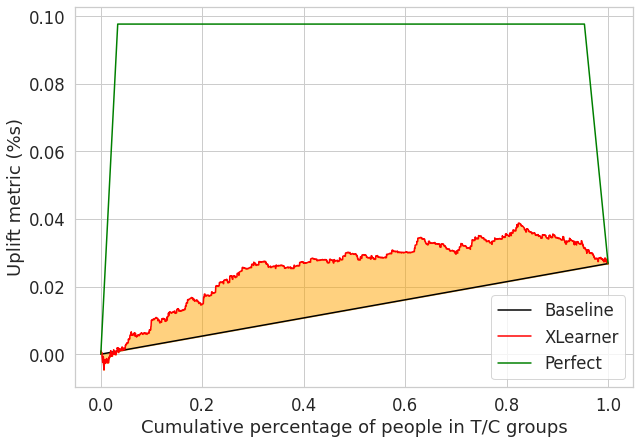

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(xs_base, ys_base, 'black')
plt.plot(xs_xlearner, ys_xlearner, 'red')
plt.plot(xs_perfect, ys_perfect, 'green')

plt.fill_between(xs_xlearner, ys_base, ys_xlearner, alpha=0.5, color='orange')

plt.xlabel('Cumulative percentage of people in T/C groups')
plt.ylabel('Uplift metric (%s)'.format(UPLIFT_METRIC))
plt.legend(['Baseline', 'XLearner', 'Perfect']);

### Uplift TOP-K

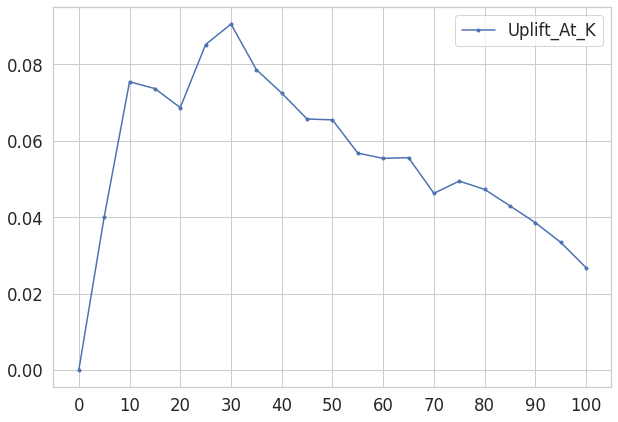

In [ ]:
tops = np.arange(0, 101, 5)

uplift_at_tops = []
for top in tops:
    uat = calculate_uplift_at_top(test_target, uplift_pred, test_treatment, top=top)
    uplift_at_tops.append(uat)

plt.figure(figsize=(10, 7))

plt.plot(tops, uplift_at_tops, marker='.')

plt.legend(['Uplift_At_K'])
plt.xticks(np.arange(0, 101, 10))
plt.show()

### Custom metric

In [ ]:
# Custom metric can be used in AutoUplift
# There msut be a function's signature:
# def custom_metric(target, uplift_pred, treatment) -> float:


class CustomUpliftMetric(TUpliftMetric):
    def __call__(self, target: np.ndarray, uplift_pred: np.ndarray, treatment: np.ndarray) -> float:
        up_10 = calculate_uplift_at_top(target, uplift_pred, treatment, 10)
        up_20 = calculate_uplift_at_top(target, uplift_pred, treatment, 20)

        return 0.5 * (up_10 + up_20)


metric = CustomUpliftMetric()
metric_value = metric(test_target, uplift_pred, test_treatment)

print("Metric = {}".format(metric_value))

Metric = 0.07204058125110756
